# Import

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import vgg16


# Load the data

In [2]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        X = data_dict[b'data']
        Y = data_dict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y
    
def load_training_data():
    X_train = []
    Y_train = []
    for i in range(1, 6):
        filename = f'./data_batch_{i}'  
        X, Y = load_batch(filename)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    return X_train, Y_train

def load_test_data():
    filename = './test_batch' 
    X_test, Y_test = load_batch(filename)
    return X_test, Y_test


# Data preprocessing

In [3]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Creating a Data Loader
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# VGG16

Files already downloaded and verified
Files already downloaded and verified


D:\datascience\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\datascience\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\12082/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:41<00:00, 13.3MB/s] 


Epoch 1: Train Loss=0.9500, Train Acc=67.24%, Val Loss=0.5930, Val Acc=80.04%
Epoch 2: Train Loss=0.5454, Train Acc=82.13%, Val Loss=0.4945, Val Acc=83.30%
Epoch 3: Train Loss=0.4293, Train Acc=85.94%, Val Loss=0.4866, Val Acc=84.03%
Epoch 4: Train Loss=0.3581, Train Acc=88.17%, Val Loss=0.4154, Val Acc=86.06%
Epoch 5: Train Loss=0.2967, Train Acc=90.22%, Val Loss=0.3984, Val Acc=87.26%
Epoch 6: Train Loss=0.2428, Train Acc=91.98%, Val Loss=0.3772, Val Acc=87.69%
Epoch 7: Train Loss=0.1956, Train Acc=93.28%, Val Loss=0.3642, Val Acc=88.53%
Epoch 8: Train Loss=0.1626, Train Acc=94.54%, Val Loss=0.3647, Val Acc=88.79%
Epoch 9: Train Loss=0.1415, Train Acc=95.24%, Val Loss=0.3660, Val Acc=89.24%
Epoch 10: Train Loss=0.1237, Train Acc=95.87%, Val Loss=0.3735, Val Acc=89.02%
Epoch 11: Train Loss=0.1213, Train Acc=95.93%, Val Loss=0.3743, Val Acc=88.94%
Epoch 12: Train Loss=0.1242, Train Acc=95.80%, Val Loss=0.3786, Val Acc=88.95%
stop


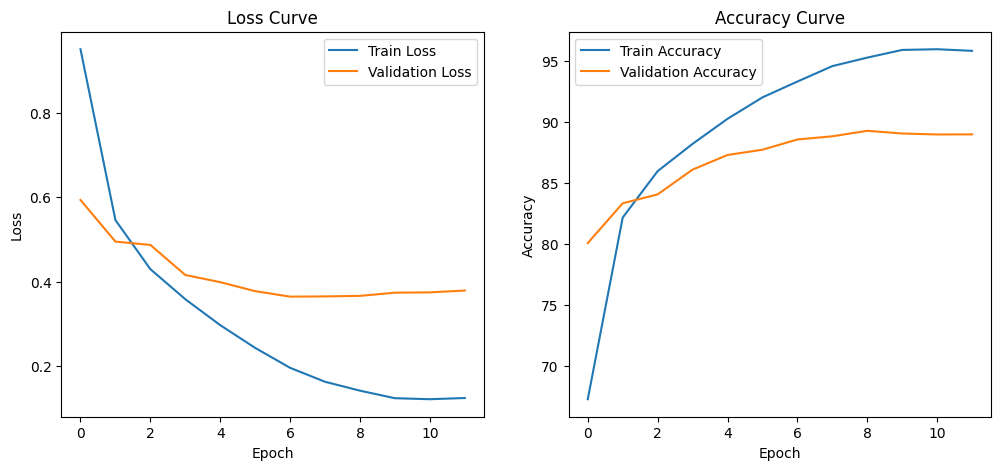

In [4]:
# Load the predefined VGG-16 model and adjust the output layer
class VGG16Modified(nn.Module):
    def __init__(self):
        super(VGG16Modified, self).__init__()
        self.model = vgg16(pretrained=True)
        self.model.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),  # 添加 Dropout 防止过拟合
            nn.Linear(4096, 10)  # 将最后的输出层调整为 CIFAR-10 的 10 个类别
        )

    def forward(self, x):
        return self.model(x)

# data enhancement
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Divide the training set and validation set
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# data loader
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
valloader = DataLoader(valset, batch_size=100, shuffle=False)

# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stop parameters
patience = 5 
best_val_loss = np.inf
early_stop_counter = 0

# Training and validation with recording of losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(50):
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Updated learning rate
    scheduler.step()

    # validation mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

    # Early Stop Mechanism
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        early_stop_counter = 0 
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("stop")
            break

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


# VGG16(without earlystop)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss=0.9279, Train Acc=68.31%, Val Loss=0.6056, Val Acc=79.41%
Epoch 2: Train Loss=0.5481, Train Acc=81.97%, Val Loss=0.5067, Val Acc=83.29%
Epoch 3: Train Loss=0.4412, Train Acc=85.41%, Val Loss=0.4342, Val Acc=85.28%
Epoch 4: Train Loss=0.3526, Train Acc=88.42%, Val Loss=0.4158, Val Acc=86.17%
Epoch 5: Train Loss=0.2908, Train Acc=90.29%, Val Loss=0.3953, Val Acc=87.19%
Epoch 6: Train Loss=0.2480, Train Acc=91.63%, Val Loss=0.4206, Val Acc=86.76%
Epoch 7: Train Loss=0.1985, Train Acc=93.25%, Val Loss=0.3676, Val Acc=88.49%
Epoch 8: Train Loss=0.1623, Train Acc=94.42%, Val Loss=0.3662, Val Acc=88.94%
Epoch 9: Train Loss=0.1420, Train Acc=95.08%, Val Loss=0.3560, Val Acc=89.20%
Epoch 10: Train Loss=0.1256, Train Acc=95.76%, Val Loss=0.3568, Val Acc=89.35%
Epoch 11: Train Loss=0.1187, Train Acc=95.97%, Val Loss=0.3585, Val Acc=89.49%
Epoch 12: Train Loss=0.1235, Train Acc=95.88%, Val Loss=0.3697, 

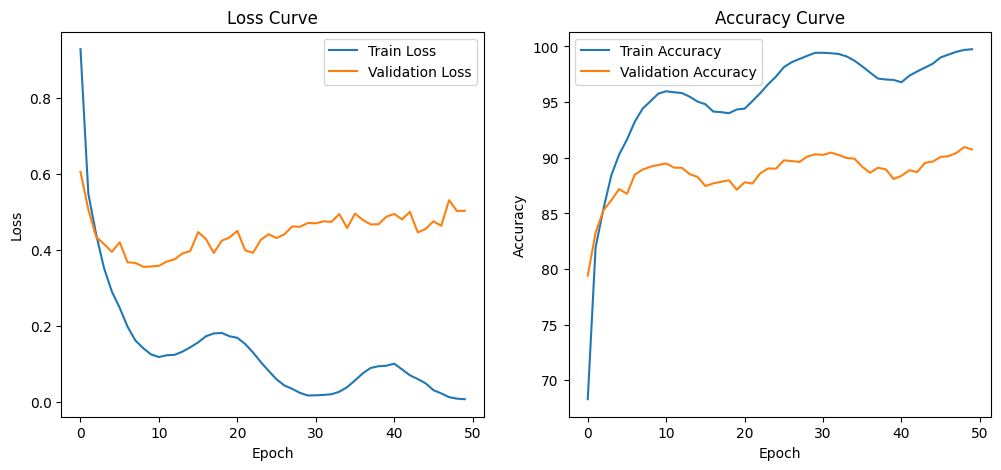

In [5]:
# Load the predefined VGG-16 model and adjust the output layer
class VGG16Modified(nn.Module):
    def __init__(self):
        super(VGG16Modified, self).__init__()
        self.model = vgg16(pretrained=True)
        self.model.classifier[6] = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        return self.model(x)

# data enhancement
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# train and validate, and record losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(50): 
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Updated learning rate
    scheduler.step()

    # validation 
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

